In [1]:
import MGBlurr.blurring as blur
import MGTomo.functions as fcts
from MGTomo.utils import mylog, mydiv
from MGTomo.optimize import armijo_linesearch, box_bounds
from MGTomo.gridop import RBox as R, PBox as P
from MGTomo import gridop

from skimage import data
from skimage.transform import resize
import matplotlib.pyplot as plt

import torch
from torch.linalg import matrix_norm

import time

In [5]:
N = 511
max_levels = 2
maxIter = [1,4,16,32,64]
kernel_size = 11
sigma = 10

# load image
x_orig = data.camera()
x_orig = resize(x_orig, (N,N), anti_aliasing = False)

x_torch = torch.tensor(x_orig, requires_grad = True)

A = [blur.GaussianBlurOperator(N, kernel_size, sigma)]
b = [torch.poisson(A[0](x_torch)*50)/50]
P_nonzero = []

fine_dim = N
for i in range(1, max_levels+1):
    coarse_dim = blur.reduce_dim(fine_dim)
    A.append(blur.GaussianBlurOperator(coarse_dim, kernel_size, sigma))
    rhs = resize(b[-1].detach().numpy(), (coarse_dim, coarse_dim), anti_aliasing=False)
    b.append(torch.tensor(rhs, requires_grad=True)) #maybe use a different way to define bH
    P_nonzero.append(gridop.compute_nonzero_elements_of_P(coarse_dim))
    fine_dim = coarse_dim
    

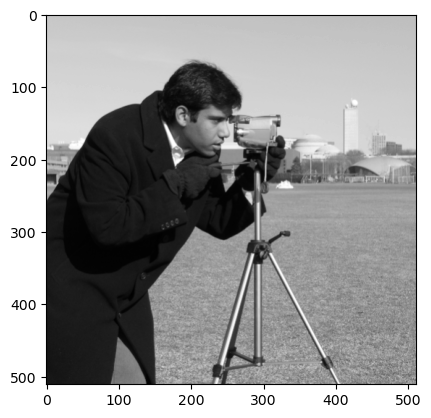

In [6]:
plt.imshow(x_orig, cmap='gray')

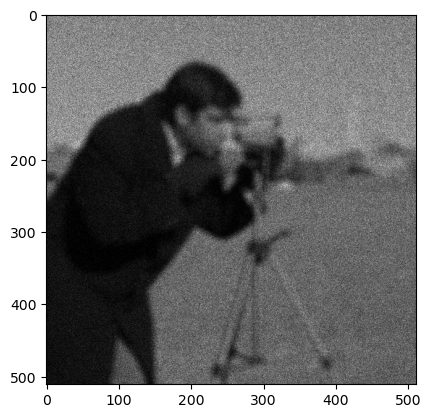

In [7]:
plt.imshow(b[0].detach(), cmap='gray')

In [3]:
def kl_distance(x: torch.tensor, A, b: torch.tensor):
    ax = A(x)
    ax.requires_grad_(True)
    #ab = torch.divide(ax, b)
    ab = mydiv(ax,b)
    
    erg = ax * mylog(ab) + b - ax
    fx = torch.sum( erg[b > 0.] ) + 0.5*torch.sum(ax[b == 0.]**2)
    #fx = torch.sum(erg[b > 0.])
    assert fx >= 0, fx
    #assert fx >= 0, 'kl distance error: output is negative.'
    return fx.requires_grad_(True)

In [4]:
tau = [0.5] * (max_levels+1)
fh = lambda x: kl_distance(x, A[0], b[0])
P_inf = 1

In [5]:
def coarse_condition_v2(y, grad_y, kappa, eta, y_last = None):
    gcond = (matrix_norm(R(grad_y)) >= kappa * matrix_norm(grad_y))
    if gcond:
        if y_last is not None:
            y_diff_norm = matrix_norm(y_last - y)
            y_norm = matrix_norm(y)
            return (y_diff_norm >= eta * y_norm)
        return True
    else:
        return False

In [6]:
w0 = torch.ones(N, N, requires_grad = True)*0.5
lh = torch.zeros_like(w0)
uh = torch.ones_like(w0)

logv_new = (w0 - lh) / (uh - w0)
w0.retain_grad()
#fh(w0).backward()
#w0.grad

fcts.BSMART_general(fh, w0, logv_new, 0.5, lh, uh)

(tensor([[0.7441, 0.7566, 0.7566,  ..., 0.7540, 0.7540, 0.7427],
         [0.7566, 0.7805, 0.7804,  ..., 0.7755, 0.7755, 0.7540],
         [0.7566, 0.7804, 0.7803,  ..., 0.7754, 0.7755, 0.7540],
         ...,
         [0.6247, 0.5048, 0.5050,  ..., 0.7468, 0.7467, 0.7389],
         [0.6246, 0.5046, 0.5048,  ..., 0.7470, 0.7469, 0.7390],
         [0.6802, 0.6246, 0.6247,  ..., 0.7391, 0.7391, 0.7351]]),
 tensor([[1.0671, 1.1342, 1.1340,  ..., 1.1198, 1.1200, 1.0600],
         [1.1342, 1.2683, 1.2679,  ..., 1.2396, 1.2399, 1.1200],
         [1.1341, 1.2680, 1.2676,  ..., 1.2393, 1.2396, 1.1199],
         ...,
         [0.5095, 0.0192, 0.0200,  ..., 1.0817, 1.0811, 1.0404],
         [0.5091, 0.0185, 0.0193,  ..., 1.0827, 1.0820, 1.0408],
         [0.7545, 0.5091, 0.5095,  ..., 1.0414, 1.0410, 1.0205]]))

In [7]:
w0 = torch.ones(N, N, requires_grad = True)*0.5
lh = torch.zeros_like(w0)
uh = torch.ones_like(w0)

rel_f_err_SL = []
rel_f_err_SL.append((matrix_norm(w0 - x_torch)/matrix_norm(w0)).item())

iteration_times_SL = []
iteration_times_SL.append(0)
overall_start_time_SL = time.time()  # Start overall timing

w0.retain_grad()

logv_new = (w0 - lh) / (uh - w0)

for i in range(100):
    iteration_start_time_SL = time.time()  # Start timing for this iteration
    
    val, logv_new = fcts.BSMART_general(fh, w0, logv_new, 0.5, lh, uh)
    
    iteration_end_time_SL = time.time()  # End timing for this iteration
    iteration_time_SL = iteration_end_time_SL - iteration_start_time_SL  # Calculate elapsed time for this iteration
    
    iteration_times_SL.append(iteration_time_SL)
    w0 = val.clone().detach().requires_grad_(True)
    rel_f_err_SL.append((matrix_norm(w0-x_torch)/matrix_norm(w0)).item())
    
    print(f"Iteration {i}: {fh(w0)} - Time: {iteration_time_SL:.6f} seconds")

overall_end_time_SL = time.time()  # End overall timing
overall_time_SL = overall_end_time_SL - overall_start_time_SL  # Calculate overall elapsed time

print(f"Overall time for all iterations: {overall_time_SL:.6f} seconds")
cumaltive_times_SL = [sum(iteration_times_SL[:i+1]) for i in range(len(iteration_times_SL))]


Iteration 0: 39623.76743430969 - Time: 0.286015 seconds
Iteration 1: 15063.159155888767 - Time: 0.244174 seconds
Iteration 2: 5599.328499539282 - Time: 0.261626 seconds
Iteration 3: 2346.773642043536 - Time: 0.245652 seconds
Iteration 4: 1143.4467250031282 - Time: 0.228116 seconds
Iteration 5: 633.3589024446319 - Time: 0.238543 seconds
Iteration 6: 385.5959515435786 - Time: 0.244174 seconds
Iteration 7: 251.26636957619706 - Time: 0.226504 seconds
Iteration 8: 172.45899019322877 - Time: 0.235746 seconds
Iteration 9: 123.64707558567798 - Time: 0.290390 seconds
Iteration 10: 92.22118891682751 - Time: 0.256422 seconds
Iteration 11: 71.36228904060395 - Time: 0.239027 seconds
Iteration 12: 57.13702749088916 - Time: 0.234494 seconds
Iteration 13: 47.17661977812219 - Time: 0.236582 seconds
Iteration 14: 40.01305724835973 - Time: 0.240468 seconds
Iteration 15: 34.71809637732691 - Time: 0.230933 seconds
Iteration 16: 30.695560008916985 - Time: 0.236265 seconds
Iteration 17: 27.55715681149345 - T

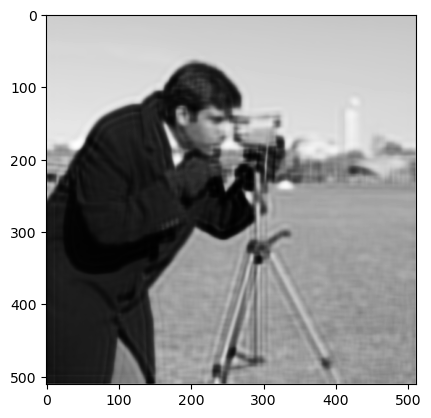

In [8]:
plt.imshow(w0.detach().numpy(), cmap = 'gray')

In [9]:
def MLO_box(fh, y, lh, uh, last_pts: list, l=0, kappa = 0.49, eps = 0.001, verbose = True):
    x = R(y).detach().requires_grad_(True)
    y0 = y.clone().detach().requires_grad_(True)
    fhy0 = fh(y)
    fhy0.backward(retain_graph=True)
    grad_fhy0 = y.grad.clone()
    y.grad.zero_()
    
    if coarse_condition_v2(y, grad_fhy0, kappa, eps, last_pts[l]):
    #if coarse_condition_v3(grad_fhy0, kappa, eps):
        print(l, ' : coarse correction activated')
        last_pts[l] = y.clone().detach()
    
        x0 = x.clone().detach().requires_grad_(True)
        fH = lambda x: fcts.kl_distance(x, A[l+1], b[l+1])
        fHx0 = fH(x0)
        fHx0.backward(retain_graph = True)
        grad_fHx0 = x0.grad.clone()
        x0.grad.zero_()

        kappa = R(grad_fhy0) - grad_fHx0

        psi = lambda x: fH(x) + torch.sum(kappa * x)
        lH, uH = box_bounds(y, x, P_inf, lh, uh, P_nonzero[l])

        logvH_new = mylog(x - lH) - mylog(uH - x)
        for i in range(maxIter[l]):
            #x.retain_grad()
            val, logvH_new = fcts.BSMART_general(psi, x, logvH_new, tau[l+1], lH, uH)
            x = val.detach().requires_grad_(True)
            
        if l < max_levels-1:
            x, last_pts = MLO_box(psi, x,lH, uH, last_pts, l+1, verbose=verbose)

        d = P(x-x0)
        z, _ = armijo_linesearch(fh, y0, d)
        y = z.detach().requires_grad_(True)
    else: 
        print(l, ' : coarse correction not activated')

    logvh_new = mylog(y - lh) - mylog(uh - y)
    
    for i in range(maxIter[l]):
        #y.retain_grad()
        yval, logvh_new = fcts.BSMART_general(fh, y, logvh_new, tau[l], lh, uh)
        y = yval.detach().requires_grad_(True)
    return y, last_pts


In [10]:
z0 = torch.ones(N, N) * 0.5
z0.requires_grad_(True)
last_pts = [None]*(max_levels+1)

lh = torch.zeros_like(z0)
uh = torch.ones_like(z0)

MLO_box(fh, z0, lh, uh, last_pts)

0  : coarse correction activated
1  : coarse correction activated


(tensor([[0.5269, 0.5536, 0.5541,  ..., 0.5486, 0.5482, 0.5241],
         [0.5536, 0.6062, 0.6071,  ..., 0.5964, 0.5955, 0.5482],
         [0.5542, 0.6072, 0.6072,  ..., 0.5964, 0.5965, 0.5487],
         ...,
         [0.3418, 0.2115, 0.2133,  ..., 0.5343, 0.5338, 0.5169],
         [0.3415, 0.2110, 0.2115,  ..., 0.5346, 0.5337, 0.5168],
         [0.4187, 0.3415, 0.3418,  ..., 0.5173, 0.5169, 0.5084]],
        requires_grad=True),
 [tensor([[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          ...,
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]]),
  tensor([[0.5511, 0.5582, 0.5567,  ..., 0.5508, 0.5521, 0.5458],
          [0.5582, 0.5662, 0.5645,  ..., 0.5579, 0.5593, 0.5521],
          [0.5568, 0.

In [11]:
z0 = torch.ones(N, N) * 0.5
z0.requires_grad_(True)
last_pts = [None]*(max_levels+1)

lh = torch.zeros_like(z0)
uh = torch.ones_like(z0)

rel_f_err = []
rel_f_err.append((matrix_norm(z0 - x_torch)/matrix_norm(z0)).item())

iteration_times_ML = []
iteration_times_ML.append(0)
overall_start_time_ML = time.time()

for i in range(100):
    iteration_start_time_ML = time.time()
    
    val, ylast = MLO_box(fh, z0, lh, uh, last_pts)
    iteration_end_time_ML = time.time()
    iteration_time_ML = iteration_end_time_ML - iteration_start_time_ML

    iteration_times_ML.append(iteration_time_ML)
    z0 = val.clone().detach().requires_grad_(True)
    rel_f_err.append((matrix_norm(z0-x_torch)/matrix_norm(z0)).item())
    
    print(f"Iteration {i}: {fh(z0)} - Time: {iteration_time_ML:.6f} seconds")

overall_end_time_ML = time.time()  # End overall timing
overall_time_ML = overall_end_time_ML - overall_start_time_ML  # Calculate overall elapsed time

print(f"Overall time for all iterations: {overall_time_ML:.6f} seconds")

cumaltive_times_ML = [sum(iteration_times_ML[:i+1]) for i in range(len(iteration_times_ML))]

0  : coarse correction activated
1  : coarse correction activated
Iteration 0: 8862.252416278505 - Time: 11.863575 seconds
0  : coarse correction activated
1  : coarse correction activated
Iteration 1: 2417.3000322560583 - Time: 12.300467 seconds
0  : coarse correction activated
1  : coarse correction activated
Iteration 2: 920.6156341184089 - Time: 11.164189 seconds
0  : coarse correction activated
1  : coarse correction activated
Iteration 3: 450.6019787766575 - Time: 11.762213 seconds
0  : coarse correction activated
1  : coarse correction activated
Iteration 4: 255.04543872387072 - Time: 9.442109 seconds
0  : coarse correction activated
1  : coarse correction not activated
Iteration 5: 160.63866296480515 - Time: 7.378946 seconds
0  : coarse correction activated
1  : coarse correction not activated
Iteration 6: 106.76377439879764 - Time: 7.483362 seconds
0  : coarse correction activated
1  : coarse correction not activated
Iteration 7: 74.1296279768743 - Time: 7.501212 seconds
0  : 